# Iterative Hessian Sketching for Regression
Code to reproduce results from https://arxiv.org/abs/1411.0347

In [117]:
import numpy as np
import scipy as sp
from sklearn.datasets import make_regression
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.linalg import norm

In [178]:
def gaussian_sketch(nrows, ncols):
    '''Generate a Gausian sketching matrix of size
    (nrows, ncols)'''
    return (1/np.sqrt(nrows))*np.random.randn(nrows, ncols)

In [92]:
def generate_data(nsamples, nfeatures, variance=1):
    '''Generates a data matrix of size (nsamples, nfeatures)
    which defines a linear relationship on the variables.'''
    X, y = make_regression(n_samples=nsamples, n_features=nfeatures,\
                        n_informative=nfeatures,noise=variance)
    X[:,0] = np.ones(shape=(nsamples)) # add bias terms
    return X, y

In [237]:
X,y = generate_data(1000,2)
X

array([[ 1.        ,  0.10980959],
       [ 1.        , -0.69993803],
       [ 1.        , -2.18847374],
       ..., 
       [ 1.        ,  1.00829309],
       [ 1.        , -2.19282429],
       [ 1.        , -0.48726985]])

In [412]:
def iterative_hessian(data, targets, num_iters):
    '''
    Add docs
    '''
    A = data
    y = targets
    n,d = A.shape
    x0 = np.zeros(shape=(d,1))
    m = n//2 # sketching dimension
    
    ATy = A.T.dot(y)
    covariance_mat = A.T.dot(A)
    print("ATy shape {}".format(ATy.shape))
    print("covar mat prod shape {}".format(covariance_mat.dot(x0).shape))
   
    
    
    for n_iter in range(num_iters):
        S = gaussian_sketch(m, n)
        S_A = S.dot(A)
        print("IP shape {}".format(np.dot(S_A.T, (np.dot(S_A,x0))).shape))
        B = S_A.T.dot(S_A)
        z = ATy - covariance_mat.dot(x0) + np.dot(S_A.T, (np.dot(S_A,x0)))
        sol = sp.linalg.lstsq(B,z)
        x_new = sol[0] 
        
        
        ### KEEP BELOW AS THIS WILL BE USED FOR LASSO OR
        ### PENALISED REGRESSION.
        
        #x0 = np.zeros((X.shape[0],1))
        #xt = np.zeros((2,1))
        #x_new = np.zeros((2,1))
        #for it in range(20):
        #    result = minimize(f2min, x0=x_new,args=(X,y,x_new),
        #                     method='L-BFGS-B', jac=False )
        #    print(result)
        #    x_new = result.x
        
        
        
        
        print(z.shape)
        x_new = sp.linalg.solve(B,z)
        print(x_new)
        print("ITERATION {}: ||x_t - x_t+1|| = {}".\
                  format(n_iter, np.linalg.norm(x0-x_new)))
        x0 = x_new
        
    
    return x0
        
        

In [413]:
x_hat = iterative_hessian(X,y, 10)

ATy shape (2,)
covar mat prod shape (2, 1)
IP shape (2, 1)
(2, 2)
[[  3.15338285  22.03505168]
 [  2.56171554  17.90062828]]
ITERATION 0: ||x_t - x_t+1|| = 28.678950559119645
IP shape (2, 2)
(2, 2)
[[  2.73600785  19.11853944]
 [  2.63303046  18.39895912]]
ITERATION 1: ||x_t - x_t+1|| = 2.9889237134314923
IP shape (2, 2)
(2, 2)
[[  2.71902871  18.9998934 ]
 [  2.61097173  18.24481823]]
ITERATION 2: ||x_t - x_t+1|| = 0.1964972703936377
IP shape (2, 2)
(2, 2)
[[  2.71776352  18.99105259]
 [  2.6126912   18.25683349]]
ITERATION 3: ||x_t - x_t+1|| = 0.015069288255894934
IP shape (2, 2)
(2, 2)
[[  2.71773758  18.99087135]
 [  2.61294529  18.25860901]]
ITERATION 4: ||x_t - x_t+1|| = 0.0018029368504805484
IP shape (2, 2)
(2, 2)
[[  2.71776776  18.99108224]
 [  2.61294586  18.25861299]]
ITERATION 5: ||x_t - x_t+1|| = 0.00021307270573610494
IP shape (2, 2)
(2, 2)
[[  2.71776592  18.99106936]
 [  2.61294313  18.25859387]]
ITERATION 6: ||x_t - x_t+1|| = 2.3290839629701993e-05
IP shape (2, 2)
(2, 

In [399]:
x_hat

array([[  2.71776581,  18.99106862],
       [  2.61294301,  18.25859309]])

In [396]:
x_true = sp.linalg.lstsq(X,y)
x_true[0]

array([  2.68324845,  18.29311045])

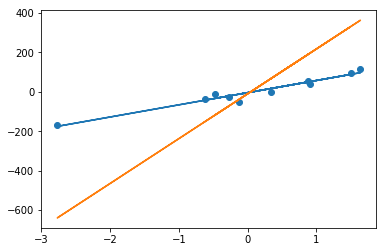

In [171]:
fig, ax = plt.subplots()

ax.scatter(X[:,1], y)
ax.plot(X[:,1], X@x_true[0])
ax.plot(X[:,1],X@x_hat)

### Checking the optimisation step
We need to use $x_{t+1} \leftarrow \text{argmin}_{x \in C} \|SA(x-x_t)\|_2^2 - (y - Ax_t)^TAx$.  To do this we will invoke the scipy minimizer but we this only minimises with one dimensional inputs so we need a local function.  

In [354]:
def lstsq(start_x, sketch, data, target):
    S = sketch #
    A = data
    y = target
    x0 = start_x
    return norm(S@A@x0-S@y)**2

In [361]:
res = minimize(lstsq, x0=np.zeros((2,1)),args=(gaussian_sketch(750,1000), X,y))

In [362]:
res

      fun: 4891280.004093261
 hess_inv: array([[ 0.00092058, -0.0009488 ],
       [-0.0009488 ,  0.00102779]])
      jac: array([ 0.,  0.])
  message: 'Optimization terminated successfully.'
     nfev: 68
      nit: 9
     njev: 17
   status: 0
  success: True
        x: array([  1.53622863,  19.1349492 ])

In [369]:
def f2min(x, data, target, offset):
    A = data
    S = np.eye(A.shape[0])
    #S = gaussian_sketch(nrows=A.shape[0]//2, ncols=A.shape[0] )
    #print(S.shape)
    #print(A.shape)
    y = target
    xt = np.ravel(offset)

    #print(xt.shape)
    #print((S@y).shape)
    #print((S@A@(x-xt)).shape)
    norm_val = norm(S@A@(x-xt))**2 #(1/2*S.shape[0])*
    inner_prod = (y - A@xt).T@A@(x-xt)
    
    return norm_val - inner_prod

In [377]:
def grad_f2min(x, data, target, offset):
    A = data
    y = target
    S = np.eye(A.shape[0])
    xt = np.ravel(offset)
    S_A = S@A
    grad = S_A.T@S_A@(x-xt) - A.T@(y-A@xt)
    
    return grad

In [385]:
x0 = np.zeros((X.shape[0],1))
xt = np.zeros((2,1))
x_new = np.zeros((2,1))
for it in range(20):
    result = minimize(f2min, x0=x_new,args=(X,y,x_new),
         method='L-BFGS-B', jac=False )
    print(result)
    x_new = result.x


      fun: -88862.213049437763
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00436557, -0.00145519])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 15
      nit: 4
   status: 0
  success: True
        x: array([ 1.34162354,  9.14655541])
      fun: -22215.552874863668
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.0003638 , -0.00145519])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 15
      nit: 4
   status: 0
  success: True
        x: array([  2.0124362,  13.7198327])
      fun: -5553.8887086430104
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 15
      nit: 4
   status: 0
  success: True
        x: array([  2.34784227,  16.00647158])
      fun: -1388.4721825066126
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.27373675e-05,  -2.2

In [386]:
result

      fun: -3.2348715651153797e-07
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -4.68895587e-06,   6.73492938e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12
      nit: 2
   status: 0
  success: True
        x: array([  2.68324587,  18.293093  ])

This now seems to be working in generality.  Keep it here for the time being in case necessary for reference at a later data.